In [1]:
import gc
import pickle

import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

GLOBAL_RANDOM_STATE = 42

# Preliminary EDA:

In [14]:
DATA_PATH = "/home/user/Documents/workspace/SBT_tasks/task4/data"
app_train = pd.read_csv(f"{DATA_PATH}/application_train.csv")
app_test = pd.read_csv(f"{DATA_PATH}/application_test.csv")
bureau = pd.read_csv(f"{DATA_PATH}/bureau.csv")
bureau_balance = pd.read_csv(f"{DATA_PATH}/bureau_balance.csv")

## Main table "application_{train|test}.csv"

In [3]:
print(app_train.describe().T)

                               count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

                                 25%   

See the target distribution:

Fraction of defaults is 8.1%


<AxesSubplot:>

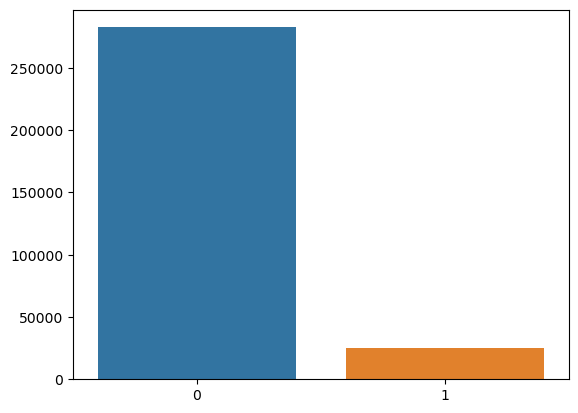

In [4]:
unique_trg, trg_cnt = np.unique(app_train["TARGET"].to_numpy(), return_counts=True)
print(f"Fraction of defaults is {100 * trg_cnt[1] / app_train.shape[0] :.1f}%")
sns.barplot(x=unique_trg, y=trg_cnt)

Compute the `null` values column-wise:

In [3]:
NULL_THRES_PERC = 60.0
NON_NULL_THRES = int(((100 - NULL_THRES_PERC) / 100) * app_train.shape[0] + 1)
NON_NULL_THRES

123005

In [4]:
def show_null(df, null_prec: int):
    nonnull_thres = int(((100 - null_prec) / 100) * df.shape[0] + 1)
    null_thres = df.shape[0] - nonnull_thres
    null_vals = df.isnull().sum()
    null_val_percent = 100 * null_vals / len(df)
    null_val_table = pd.concat([null_vals, null_val_percent], axis=1)
    null_val_table_ren_columns = null_val_table.rename(
        columns={0: "Null Values", 1: "% of Null Values"}
    )
    null_val_table_ren_columns = (
        null_val_table_ren_columns[null_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Null Values", ascending=False)
        .round(1)
    )
    null_idx = null_val_table_ren_columns["Null Values"] > null_thres
    return (
        null_val_table_ren_columns,
        null_val_table_ren_columns["Null Values"][null_idx].index,
    )

In [5]:
null_val_info, null_cols = show_null(app_train, NULL_THRES_PERC)
print(null_cols)
null_val_info.head(10)

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE'],
      dtype='object')


,Null Values,% of Null Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


See which features correlate to the target:

In [6]:
corr_sorted = app_train.corr()["TARGET"].sort_values(ascending=False)
top_n_corr = 30
top_corr_idx = np.arange(1, top_n_corr + 1)
top_corr = corr_sorted[[*top_corr_idx, *(-top_corr_idx[::-1])]]
top_corr_features = top_corr.index.to_list()
print(top_corr)

DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
REG_REGION_NOT_WORK_REGION     0.006942
REG_REGION_NOT_LIVE_REGION     0.005576
FLAG_DOCUMENT_2                0.005417
FLAG_DOCUMENT_21               0.003709
LIVE_REGION_NOT_WORK_REGION    0.002819


We looked at Top 3 features correlating positively and negatively to the target feature, and concluded that none of the features correlates to the target individually. However, we can investigate how these top correlating features affect target.

Text(0.5, 1.0, 'Age Distribution of Clients')

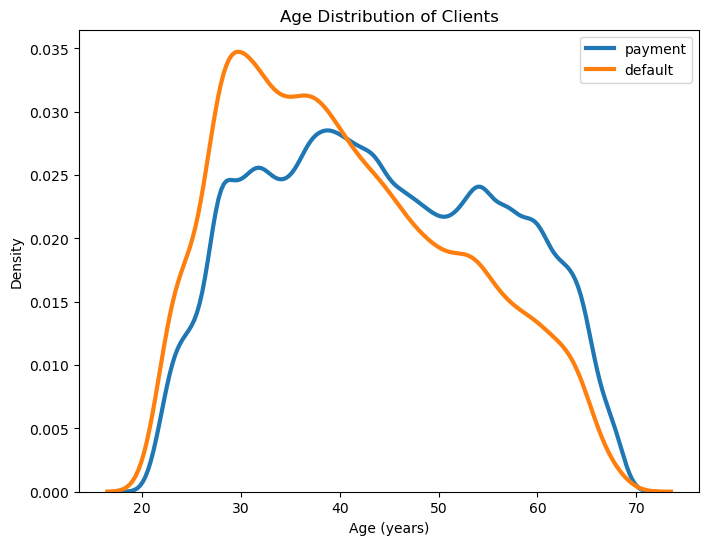

In [9]:
app_train["DAYS_BIRTH"] = np.abs(app_train["DAYS_BIRTH"])
plt.figure(figsize=(8, 6))
sns.kdeplot(
    app_train.loc[app_train["TARGET"] == 0, "DAYS_BIRTH"] / 365,
    label="payment",
    linewidth=3,
)
sns.kdeplot(
    app_train.loc[app_train["TARGET"] == 1, "DAYS_BIRTH"] / 365,
    label="default",
    linewidth=3,
)
plt.legend()
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.title("Age Distribution of Clients")

We can see, that among the ones who defaultend on their loan, ~30 is the most common age.

Text(0.5, 1.0, 'Region Rating Distribution of Clients')

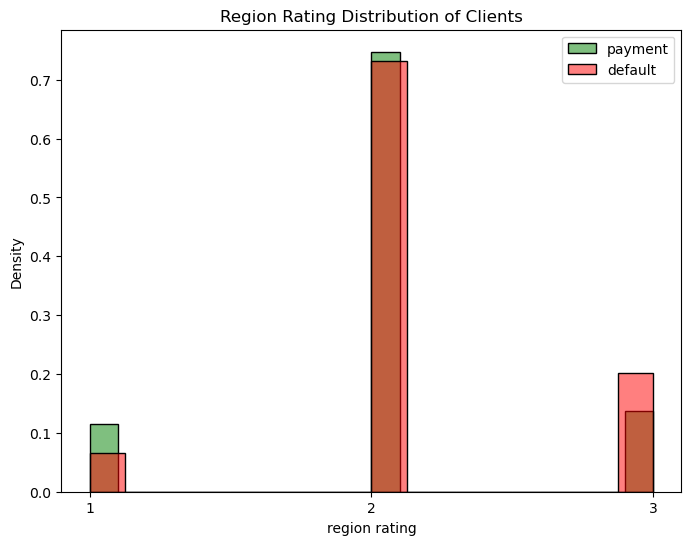

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(
    app_train.loc[app_train["TARGET"] == 0, "REGION_RATING_CLIENT_W_CITY"],
    label="payment",
    stat="probability",
    color="green",
    alpha=0.5,
)
sns.histplot(
    app_train.loc[app_train["TARGET"] == 1, "REGION_RATING_CLIENT_W_CITY"],
    label="default",
    stat="probability",
    color="red",
    alpha=0.5,
)
plt.legend()
plt.xlabel("region rating")
plt.ylabel("Density")
plt.xticks([1, 2, 3])
plt.title("Region Rating Distribution of Clients")

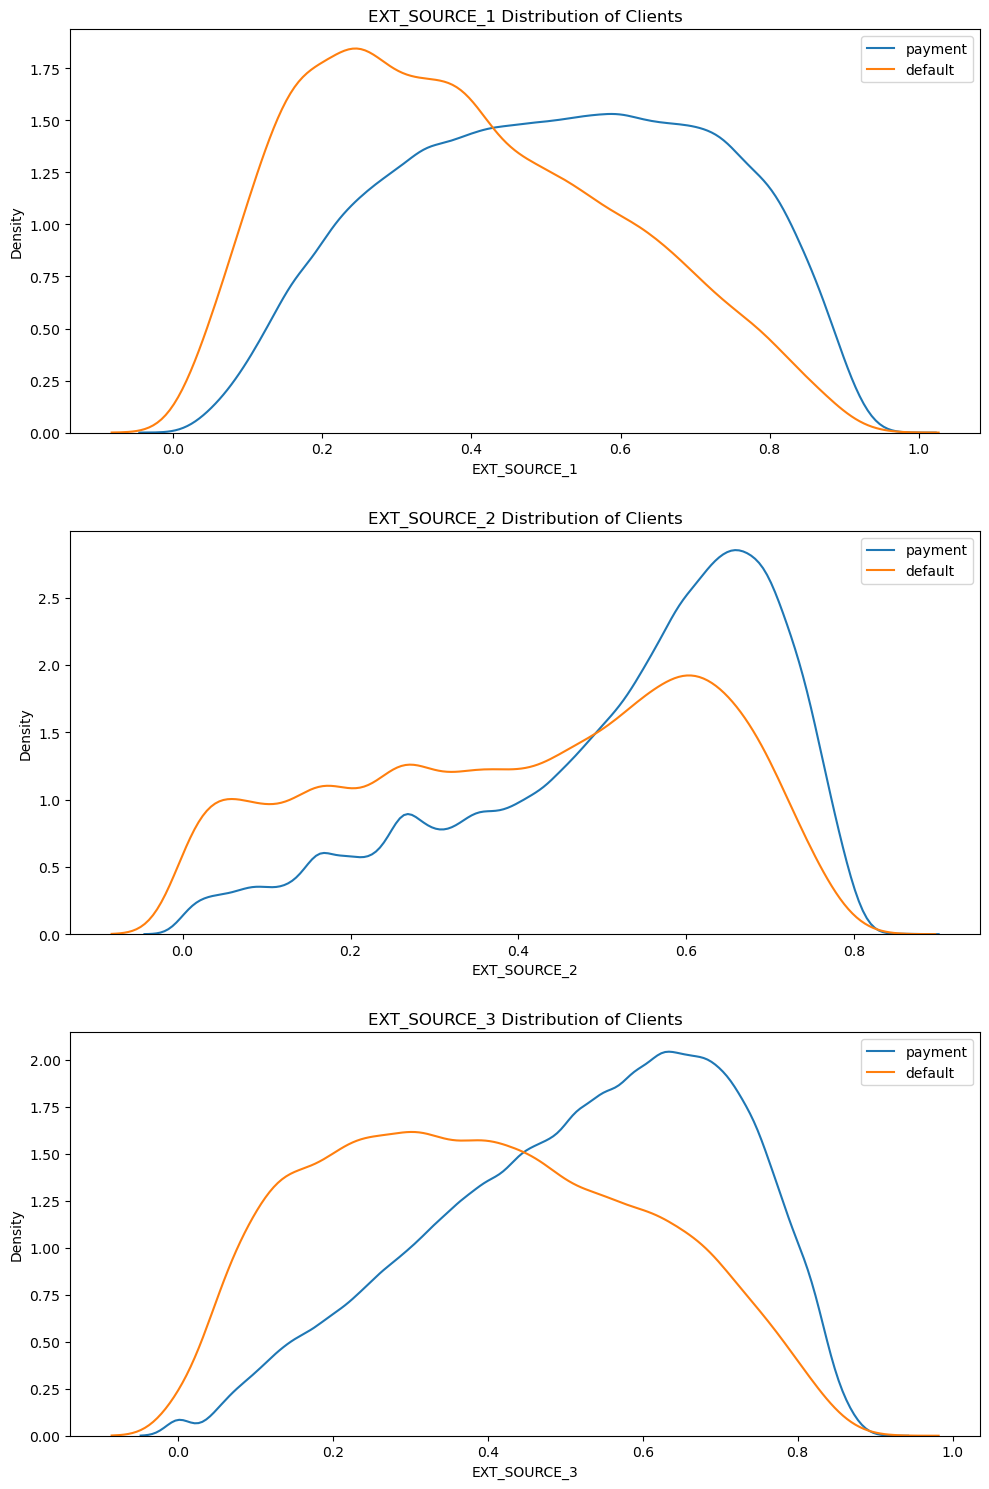

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 15))
for i in range(3):
    sns.kdeplot(
        data=app_train.loc[app_train["TARGET"] == 0, f"EXT_SOURCE_{i+1}"],
        ax=axes[i],
        label="payment",
    )
    sns.kdeplot(
        data=app_train.loc[app_train["TARGET"] == 1, f"EXT_SOURCE_{i+1}"],
        ax=axes[i],
        label="default",
    )
    axes[i].legend()
    axes[i].set_xlabel(f"EXT_SOURCE_{i+1}")
    axes[i].set_ylabel("Density")
    axes[i].set_title(f"EXT_SOURCE_{i+1} Distribution of Clients")
plt.tight_layout(h_pad=2.5)

We can see, that EXT_SOURCE_1 correlates to target almost negative as much as the age, and the distibutions by target are very similar.

In [13]:
app_train.shape, app_train.drop_duplicates().shape

((307511, 122), (307511, 122))

Text(0.5, 1.0, 'Gender Distribution of Clients by TARGET')

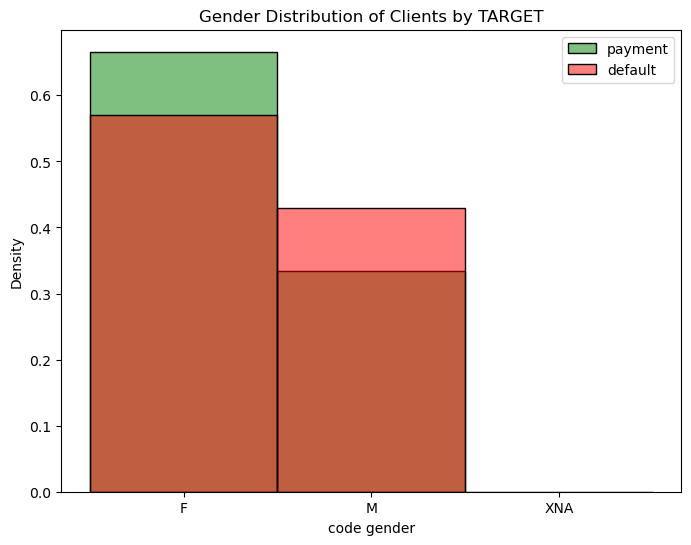

In [103]:
plt.figure(figsize=(8, 6))
sns.histplot(
    app_train.loc[app_train["TARGET"] == 0, "CODE_GENDER"],
    label="payment",
    stat="probability",
    color="green",
    alpha=0.5,
)
sns.histplot(
    app_train.loc[app_train["TARGET"] == 1, "CODE_GENDER"],
    label="default",
    stat="probability",
    color="red",
    alpha=0.5,
)
plt.legend()
plt.xlabel("code gender")
plt.ylabel("Density")
plt.title("Gender Distribution of Clients by TARGET")

We can see, there are more females in both payment, and default, so that's why their correlation to the target was low.

## bureau|bureau_balance.csv

In [76]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [77]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [86]:
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08


In [87]:
bureau_balance.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0


In [84]:
show_null(bureau).head(10)

,Null Values,% of Null Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [85]:
show_null(bureau_balance).head(10)

,Null Values,% of Null Values


In Credit Bureau we are interested in the status of the credit and the type of the credit:

<AxesSubplot:xlabel='CREDIT_ACTIVE', ylabel='count'>

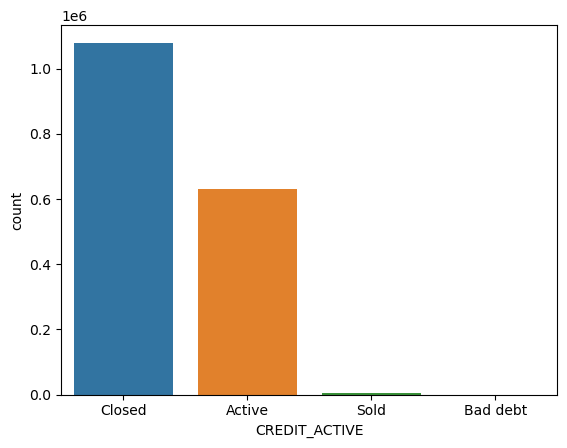

In [91]:
sns.countplot(data=bureau, x="CREDIT_ACTIVE")

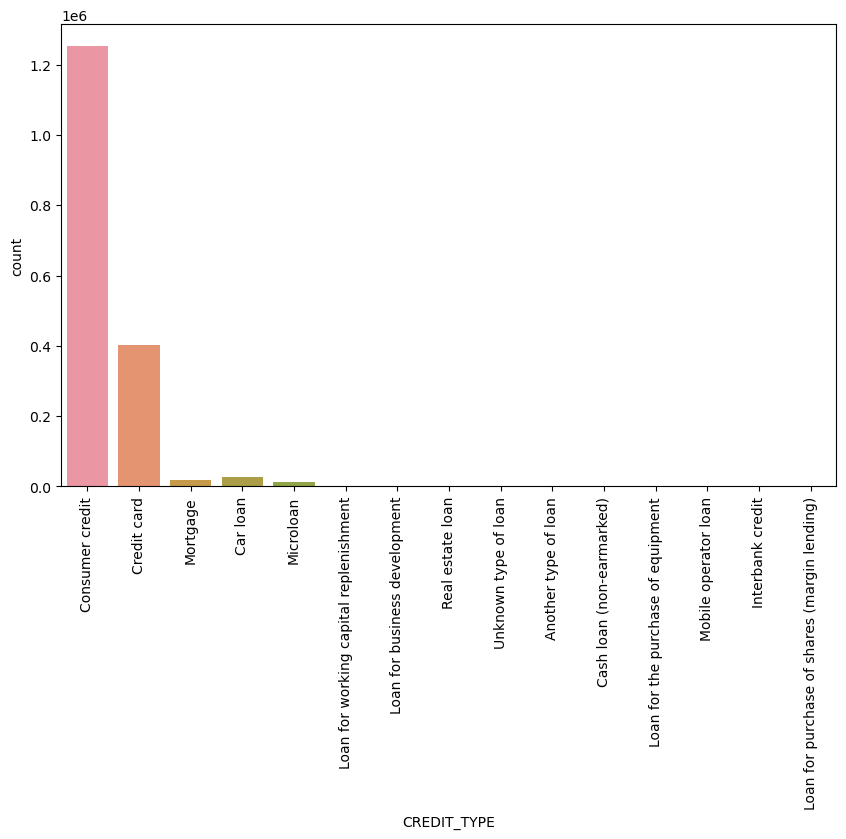

In [101]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bureau, x="CREDIT_TYPE")
plt.xticks(rotation=90)
plt.show()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64


<AxesSubplot:xlabel='STATUS', ylabel='count'>

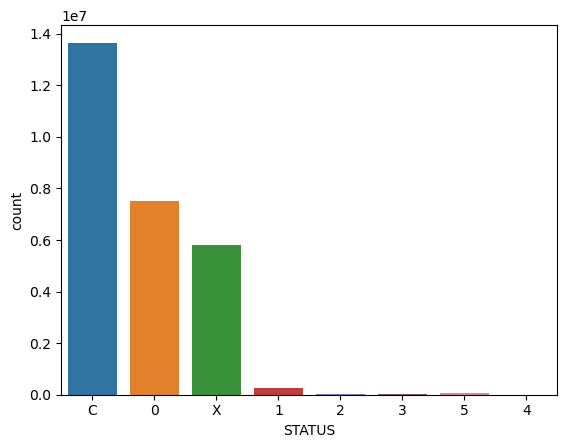

In [111]:
print(bureau_balance["STATUS"].value_counts())
sns.countplot(data=bureau_balance, x="STATUS")

# Preprocessing

In [15]:
app_train["DAYS_BIRTH"] = np.abs(app_train["DAYS_BIRTH"]) / 365
app_test["DAYS_BIRTH"] = np.abs(app_test["DAYS_BIRTH"]) / 365
app_train["DAYS_EMPLOYED"] = np.abs(app_train["DAYS_EMPLOYED"]) / 365
app_test["DAYS_EMPLOYED"] = np.abs(app_test["DAYS_EMPLOYED"]) / 365

In [7]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(
    trn_series=None,
    tst_series=None,
    target=None,
    min_samples_leaf=1,
    smoothing=1,
    noise_level=0,
):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = (
        pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(
                columns={"index": target.name, target.name: "average"}
            ),
            on=trn_series.name,
            how="left",
        )["average"]
        .rename(trn_series.name + "_mean")
        .fillna(prior)
    )
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = (
        pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(
                columns={"index": target.name, target.name: "average"}
            ),
            on=tst_series.name,
            how="left",
        )["average"]
        .rename(trn_series.name + "_mean")
        .fillna(prior)
    )
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

We'll select only top 15 positively correlated features and top 15 negatively correlated features to the target. We'll delete columns having more than 60% NaN or null values. In other cases we will fill null and nan values with mean or mode.

In [7]:
# app_train = app_train[["SK_ID_CURR", *top_corr_features, "TARGET"]]
# app_test = app_test[["SK_ID_CURR", *top_corr_features]]
# print(app_train.shape, app_test.shape)

(307511, 62) (48744, 61)


In [16]:
null_cols_1 = list(set(app_test.columns).intersection(null_cols))
app_train.drop(columns=null_cols_1, inplace=True)
app_test.drop(columns=null_cols_1, inplace=True)
print(app_train.shape, app_test.shape)

(307511, 105) (48744, 104)


In [17]:
from sklearn.impute import SimpleImputer

In [18]:
app_train.isnull().sum().sum(), app_test.isnull().sum().sum()

(5584117, 847592)

In [19]:
imputer = {
    "median": SimpleImputer(strategy="mean"),
    "mode": SimpleImputer(strategy="most_frequent"),
}
for col in app_test.columns:
    if app_train[col].dtype != "object":
        app_train[col] = imputer["median"].fit_transform(app_train[col].to_numpy().reshape((-1, 1)))
        app_test[col] = imputer["median"].transform(app_test[col].to_numpy().reshape((-1, 1)))
    else:
        app_train[col] = imputer["mode"].fit_transform(app_train[col].to_numpy().reshape((-1, 1)))
        app_test[col] = imputer["mode"].transform(app_test[col].to_numpy().reshape((-1, 1)))

In [20]:
app_train.isnull().sum().sum(), app_test.isnull().sum().sum()

(0, 0)

Encoding categorical variables using target encoding:

In [21]:
for col in app_test.columns:
    if app_train[col].dtype == "object":
        app_train[col], app_test[col] = target_encode(
            app_train[col], app_test[col], app_train["TARGET"]
        )
print(app_train.shape, app_test.shape)

(307511, 105) (48744, 104)


In [91]:
# app_train, app_test = pd.get_dummies(app_train), pd.get_dummies(app_test)
# print(app_train.shape, app_test.shape)

(307511, 226) (48744, 222)


In [22]:
set(app_train.columns).difference(app_test.columns.to_list())

{'TARGET'}

In [93]:
# app_test["CODE_GENDER_XNA"] = np.zeros(len(app_test))
# app_test["NAME_FAMILY_STATUS_Unknown"] = np.zeros(len(app_test))
# app_test["NAME_INCOME_TYPE_Maternity leave"] = np.zeros(len(app_test))
# app_test["TARGET"] = np.zeros(len(app_test))
# app_test = app_test[app_train.columns].drop(columns=["TARGET"])
# print(app_train.shape, app_test.shape)

(307511, 226) (48744, 225)


# Aggregation

In [106]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## bureau | bureau_balance.csv

In [23]:
numerical_cols = [
    *[col for col in bureau.columns if bureau[col].dtype != "object"],
    *[col for col in bureau_balance.columns if bureau_balance[col].dtype != "object"],
]

In [24]:
br_oh_df = pd.get_dummies(bureau)
br_enc_cols = [c for c in br_oh_df.columns if c not in numerical_cols]
bb_oh_df = pd.get_dummies(bureau_balance)
bb_enc_cols = [c for c in bb_oh_df.columns if c not in numerical_cols]

In [25]:
br_oh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 37 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   SK_ID_BUREAU                                              int64  
 2   DAYS_CREDIT                                               int64  
 3   CREDIT_DAY_OVERDUE                                        int64  
 4   DAYS_CREDIT_ENDDATE                                       float64
 5   DAYS_ENDDATE_FACT                                         float64
 6   AMT_CREDIT_MAX_OVERDUE                                    float64
 7   CNT_CREDIT_PROLONG                                        int64  
 8   AMT_CREDIT_SUM                                            float64
 9   AMT_CREDIT_SUM_DEBT                                       float64
 10  AMT_CREDIT_SUM_LIMIT          

In [26]:
aggs = {
    "MONTHS_BALANCE": ["min", "max", "size"],
}
for col in bb_enc_cols:
    aggs[col] = ["mean"]
bb_agg = bb_oh_df.groupby("SK_ID_BUREAU").agg(aggs)
bb_agg

MONTHS_BALANCE           STATUS_0  STATUS_1 STATUS_2 STATUS_3  \
                        min max size      mean      mean     mean     mean   
SK_ID_BUREAU                                                                 
5001709                 -96   0   97  0.000000  0.000000      0.0      0.0   
5001710                 -82   0   83  0.060241  0.000000      0.0      0.0   
5001711                  -3   0    4  0.750000  0.000000      0.0      0.0   
5001712                 -18   0   19  0.526316  0.000000      0.0      0.0   
5001713                 -21   0   22  0.000000  0.000000      0.0      0.0   
...                     ...  ..  ...       ...       ...      ...      ...   
6842884                 -47   0   48  0.187500  0.000000      0.0      0.0   
6842885                 -23   0   24  0.500000  0.000000      0.0      0.0   
6842886                 -32   0   33  0.242424  0.000000      0.0      0.0   
6842887                 -36   0   37  0.162162  0.000000      0.0      0.0   
6842888                 -61   0   62  0.145161  0.016129      0.0      0.0   

             STATUS_4 STATUS_5  STATUS_C  STATUS_X  
                 mean     mean      mean      mean  
SK_ID_BUREAU                                        
5001709           0.0      0.0  0.886598  0.113402  
5001710           0.0      0.0  0.578313  0.361446  
5001711           0.0      0.0  0.000000  0.250000  
5001712           0.0      0.0  0.473684  0.000000  
5001713           0.0      0.0  0.000000  1.000000  
...               ...      ...       ...       ...  
6842884           0.0      0.0  0.416667  0.395833  
6842885           0.0      0.5  0.000000  0.000000  
6842886           0.0      0.0  0.757576  0.000000  
6842887           0.0      0.0  0.837838  0.000000  
6842888           0.0      0.0  0.838710  0.000000  

[817395 rows x 11 columns]

In [58]:
bb_agg.columns.map(lambda x: x[0] + "_" + x[1].upper())

Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
       'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN',
       'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN'],
      dtype='object')

In [27]:
new_agg_cols = [f"{col[0]}_{col[1].upper()}" for col in bb_agg.columns]
new_agg_cols

['MONTHS_BALANCE_MIN',
 'MONTHS_BALANCE_MAX',
 'MONTHS_BALANCE_SIZE',
 'STATUS_0_MEAN',
 'STATUS_1_MEAN',
 'STATUS_2_MEAN',
 'STATUS_3_MEAN',
 'STATUS_4_MEAN',
 'STATUS_5_MEAN',
 'STATUS_C_MEAN',
 'STATUS_X_MEAN']

In [28]:
bb_agg.columns = pd.Index(new_agg_cols)
bb_agg

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
SK_ID_BUREAU,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402
5001710,-82,0,83,0.060241,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446
5001711,-3,0,4,0.750000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000
5001712,-18,0,19,0.526316,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000
5001713,-21,0,22,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
6842884,-47,0,48,0.187500,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833
6842885,-23,0,24,0.500000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000
6842886,-32,0,33,0.242424,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000


In [29]:
br_oh_df.set_index("SK_ID_BUREAU", inplace=True)
br_merged = br_oh_df.merge(bb_agg, how="left", on="SK_ID_BUREAU")
br_merged

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5714462,215354,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5714463,215354,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5714464,215354,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5714465,215354,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5714466,215354,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057750,259355,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5057754,100044,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5057762,100044,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
br_oh_df.shape, bb_agg.shape, br_merged.shape

((1716428, 36), (817395, 11), (1716428, 47))

In [30]:
# create different statistics of features
num_aggs = {
    "AMT_ANNUITY": ["max", "mean"],
    "DAYS_CREDIT": ["min", "max", "mean", "sum"],
    "CREDIT_DAY_OVERDUE": ["max", "mean", "sum"],
    "DAYS_CREDIT_ENDDATE": ["min", "max", "mean", "sum"],
    "DAYS_ENDDATE_FACT": ["min", "max", "mean", "sum"],
    "AMT_CREDIT_MAX_OVERDUE": ["min", "max", "mean", "sum"],
    "CNT_CREDIT_PROLONG": ["min", "max", "mean", "sum"],
    "AMT_CREDIT_SUM": ["max", "mean", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
    "AMT_CREDIT_SUM_LIMIT": ["max", "mean", "sum"],
    "AMT_CREDIT_SUM_OVERDUE": ["max", "mean", "sum"],
}

category_aggs = {}
for category in br_enc_cols:
    category_aggs[category] = ["mean"]
for category in bb_enc_cols:
    category_aggs[category + "_MEAN"] = ["mean"]

br_agg = br_merged.groupby("SK_ID_CURR").agg({**num_aggs, **category_aggs})
br_agg.columns = pd.Index([f"{col[0]}_{col[1].upper()}" for col in br_agg.columns])
br_agg

,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,DAYS_CREDIT_SUM,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_SUM,DAYS_CREDIT_ENDDATE_MIN,...,CREDIT_TYPE_Real estate loan_MEAN,CREDIT_TYPE_Unknown type of loan_MEAN,STATUS_0_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_4_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_C_MEAN_MEAN,STATUS_X_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,10822.5,3545.357143,-1572,-49,-735.000000,-5145,0,0.0,0,-1329.0,...,0.0,0.0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590
100002,0.0,0.000000,-1437,-103,-874.000000,-6992,0,0.0,0,-1072.0,...,0.0,0.0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932
100003,NaN,NaN,-2586,-606,-1400.750000,-5603,0,0.0,0,-2434.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,-1326,-408,-867.000000,-1734,0,0.0,0,-595.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4261.5,1420.500000,-373,-62,-190.666667,-572,0,0.0,0,-128.0,...,0.0,0.0,0.735043,0.000000,0.0,0.0,0.0,0.0,0.128205,0.136752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,NaN,NaN,-2713,-483,-1667.076923,-21672,0,0.0,0,-2499.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456250,384147.0,154567.965000,-1002,-760,-862.000000,-2586,0,0.0,0,-272.0,...,0.0,0.0,0.130259,0.000000,0.0,0.0,0.0,0.0,0.252525,0.617216
456253,58369.5,58369.500000,-919,-713,-867.500000,-3470,0,0.0,0,-189.0,...,0.0,0.0,0.404906,0.000000,0.0,0.0,0.0,0.0,0.459677,0.135417


In [31]:
CORR_THRESHOLD = 0.0005
br_agg_target = app_train[["SK_ID_CURR", "TARGET"]].merge(
    br_agg, how="inner", on="SK_ID_CURR"
)
br_agg_target.fillna(0, inplace=True)
corrs = br_agg_target.corr()
corrs = corrs.sort_values(by="TARGET", key=lambda col: abs(col), ascending=False)
top_corr = pd.DataFrame(corrs["TARGET"])
top_corr = top_corr.loc[top_corr["TARGET"] >= CORR_THRESHOLD]
top_corr_list = top_corr.index.values.tolist()
del top_corr_list[0]
top_corr_list.append("top_corr_list")
br_agg = br_agg[br_agg.columns.intersection(top_corr_list)]

In [32]:
br_agg.shape

(305811, 42)

In [68]:
print(top_corr)

                                                      TARGET
TARGET                                              1.000000
DAYS_CREDIT_MEAN                                    0.089729
CREDIT_ACTIVE_Active_MEAN                           0.077356
DAYS_CREDIT_MIN                                     0.075248
DAYS_ENDDATE_FACT_MIN                               0.067973
DAYS_ENDDATE_FACT_MEAN                              0.065805
DAYS_CREDIT_ENDDATE_SUM                             0.053735
DAYS_CREDIT_MAX                                     0.049782
DAYS_ENDDATE_FACT_SUM                               0.048854
DAYS_CREDIT_ENDDATE_MEAN                            0.046532
CREDIT_TYPE_Microloan_MEAN                          0.044439
DAYS_CREDIT_SUM                                     0.042000
STATUS_1_MEAN_MEAN                                  0.038747
DAYS_CREDIT_ENDDATE_MAX                             0.035927
CREDIT_TYPE_Credit card_MEAN                        0.034684
DAYS_CREDIT_ENDDATE_MIN 

In [33]:
train = app_train.merge(br_agg, how="left", on="SK_ID_CURR")
# train.fillna(0, inplace=True)
print(train.shape)
train.head(10)

(307511, 147)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Credit card_MEAN,CREDIT_TYPE_Loan for working capital replenishment_MEAN,CREDIT_TYPE_Microloan_MEAN,STATUS_0_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_4_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_X_MEAN_MEAN
0,100002.0,1,0.083459,0.101419,0.085002,0.079616,0.0,202500.0,406597.5,24700.5,...,0.500000,0.0,0.0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.161932
1,100003.0,0,0.083459,0.069993,0.085002,0.083249,0.0,270000.0,1293502.5,35698.5,...,0.500000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004.0,0,0.054783,0.101419,0.072437,0.079616,0.0,67500.0,135000.0,6750.0,...,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006.0,0,0.083459,0.069993,0.085002,0.079616,0.0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007.0,0,0.083459,0.101419,0.085002,0.079616,0.0,121500.0,513000.0,21865.5,...,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100008.0,0,0.083459,0.101419,0.085002,0.079616,0.0,99000.0,490495.5,27517.5,...,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100009.0,0,0.083459,0.069993,0.072437,0.079616,1.0,171000.0,1560726.0,41301.0,...,0.111111,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100010.0,0,0.083459,0.101419,0.072437,0.079616,0.0,360000.0,1530000.0,42075.0,...,0.000000,0.0,0.0,0.277778,0.000000,0.0,0.0,0.0,0.0,0.000000
8,100011.0,0,0.083459,0.069993,0.085002,0.079616,0.0,112500.0,1019610.0,33826.5,...,0.250000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100012.0,0,0.054783,0.101419,0.085002,0.079616,0.0,135000.0,405000.0,20250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
test = pd.get_dummies(app_test).merge(br_agg, how="left", on="SK_ID_CURR")
# test.fillna(0, inplace=True)
print(test.shape)
test.head()

(48744, 146)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CREDIT_TYPE_Credit card_MEAN,CREDIT_TYPE_Loan for working capital replenishment_MEAN,CREDIT_TYPE_Microloan_MEAN,STATUS_0_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_4_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_X_MEAN_MEAN
0,100001.0,0.083459,0.069993,0.085002,0.079616,0.0,135000.0,568800.0,20560.5,450000.0,...,0.000000,0.0,0.0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.214590
1,100005.0,0.083459,0.101419,0.085002,0.079616,0.0,99000.0,222768.0,17370.0,180000.0,...,0.333333,0.0,0.0,0.735043,0.000000,0.0,0.0,0.0,0.0,0.136752
2,100013.0,0.083459,0.101419,0.072437,0.079616,0.0,202500.0,663264.0,69777.0,630000.0,...,0.000000,0.0,0.0,0.320718,0.027701,0.0,0.0,0.0,0.0,0.254545
3,100028.0,0.083459,0.069993,0.085002,0.079616,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.416667,0.0,0.0,0.377321,0.000000,0.0,0.0,0.0,0.0,0.260434
4,100038.0,0.083459,0.101419,0.072437,0.083249,1.0,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Previous applications

In [91]:
prev = pd.read_csv(f"{DATA_PATH}/previous_application.csv")
credit_card = pd.read_csv(f"{DATA_PATH}/credit_card_balance.csv")
POS_CASH = pd.read_csv(f"{DATA_PATH}/POS_CASH_balance.csv")
payments = pd.read_csv(f"{DATA_PATH}/installments_payments.csv")

In [92]:
prev.head(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == "object"]
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby("SK_ID_CURR").mean()
cnt_prev = prev[["SK_ID_CURR", "SK_ID_PREV"]].groupby("SK_ID_CURR").count()
avg_prev["nb_app"] = cnt_prev["SK_ID_PREV"]
avg_prev.drop(columns=["SK_ID_PREV"], inplace=True)
avg_prev

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,nb_app
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000000,24835.500,23787.00,2520.00,24835.500,13.000000,1.0,0.104326,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,1
100002,9251.775000,179055.000,179055.00,0.00,179055.000,9.000000,1.0,0.000000,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,1.0,0.0,1
100003,56553.990000,435436.500,484191.00,3442.50,435436.500,14.666667,1.0,0.050030,NaN,NaN,...,0.00,0.333333,0.0,0.333333,0.0,0.00,0.0,0.0,0.0,3
100004,5357.250000,24282.000,20106.00,4860.00,24282.000,5.000000,1.0,0.212008,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,0.00,1.0,0.0,0.0,1
100005,4813.200000,22308.750,20076.75,4464.00,44617.500,10.500000,1.0,0.108964,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,0.50,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910000,40455.000,40455.00,0.00,40455.000,17.000000,1.0,0.000000,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,1
456252,10074.465000,57595.500,56821.50,3456.00,57595.500,10.000000,1.0,0.062443,NaN,NaN,...,0.00,0.000000,1.0,0.000000,0.0,0.00,0.0,0.0,0.0,1
456253,4770.405000,24162.750,20625.75,4403.25,24162.750,11.500000,1.0,0.214316,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,2


In [104]:
POS_CASH.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [105]:
POS_CASH.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [107]:
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS_MAX'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
POS_CASH

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NUNIQUE_STATUS,NUNIQUE_STATUS_MAX
0,182943,-31,48.0,45.0,0,0,NaN,NaN
1,367990,-33,36.0,35.0,0,0,NaN,NaN
2,397406,-32,12.0,9.0,0,0,NaN,NaN
3,269225,-35,48.0,42.0,0,0,NaN,NaN
4,334279,-35,36.0,35.0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
10001353,226558,-20,6.0,0.0,843,0,NaN,NaN
10001354,141565,-19,12.0,0.0,602,0,NaN,NaN
10001355,315695,-21,10.0,0.0,609,0,NaN,NaN
10001356,450255,-22,12.0,0.0,614,0,NaN,NaN


In [108]:
credit_card.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [109]:
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS_MAX'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

In [110]:
payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [111]:
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
avg_payments.drop(columns=["SK_ID_PREV"], inplace=True)

In [112]:
train = train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

del avg_prev, POS_CASH, credit_card, avg_payments, avg_payments2, avg_payments3
gc.collect()

17043

In [113]:
train.shape, test.shape

((307511, 359), (48744, 358))

# Modelling

In [114]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    recall_score,
    precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [117]:
X = train.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE
)

In [118]:
print(y_test.value_counts())
print(y_train.value_counts())

0    56554
1     4949
Name: TARGET, dtype: int64
0    226132
1     19876
Name: TARGET, dtype: int64


## KNN

In [213]:
from sklearn.neighbors import KNeighborsClassifier

In [233]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [234]:
print(y_smote.value_counts())

0.0    226132
1.0    226132
Name: TARGET, dtype: int64


In [235]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_smote, y_smote)
knn_preds = knn.predict_proba(X_test)
knn_score = roc_auc_score(y_test, knn_preds[:, 1])
print(knn_score)

0.5404726612980142


## CatBoost

In [115]:
from catboost import CatBoostClassifier, Pool

In [119]:
class_weigths = compute_class_weight(class_weight="balanced", classes=[0, 1], y=y_train)
class_weigths

array([0.54394778, 6.18856913])

In [120]:
cb = CatBoostClassifier(
    task_type="GPU",
    devices="0",
    iterations=1000,
    class_weights=class_weigths,
)
cb.fit(X_train, y_train)
cb_preds = cb.predict_proba(X_test)
cb_score = roc_auc_score(y_test, cb_preds[:, 1])
print(cb_score)

Learning rate set to 0.024904
0:	learn: 0.6894108	total: 10.2ms	remaining: 10.2s
1:	learn: 0.6858055	total: 19.7ms	remaining: 9.81s
2:	learn: 0.6824009	total: 29.3ms	remaining: 9.75s
3:	learn: 0.6791653	total: 39.3ms	remaining: 9.78s
4:	learn: 0.6761027	total: 49.4ms	remaining: 9.82s
5:	learn: 0.6731237	total: 58.6ms	remaining: 9.7s
6:	learn: 0.6703338	total: 68.5ms	remaining: 9.72s
7:	learn: 0.6675908	total: 77.7ms	remaining: 9.64s
8:	learn: 0.6650610	total: 87.8ms	remaining: 9.66s
9:	learn: 0.6626582	total: 96.6ms	remaining: 9.56s
10:	learn: 0.6603012	total: 106ms	remaining: 9.54s
11:	learn: 0.6580185	total: 116ms	remaining: 9.52s
12:	learn: 0.6559410	total: 124ms	remaining: 9.45s
13:	learn: 0.6539242	total: 134ms	remaining: 9.42s
14:	learn: 0.6519261	total: 143ms	remaining: 9.37s
15:	learn: 0.6500411	total: 151ms	remaining: 9.31s
16:	learn: 0.6482510	total: 160ms	remaining: 9.26s
17:	learn: 0.6465096	total: 169ms	remaining: 9.22s
18:	learn: 0.6448491	total: 178ms	remaining: 9.19s
19

In [90]:
roc_auc_score(y_test, 0.7 * np.ones(len(X_test)))

0.5

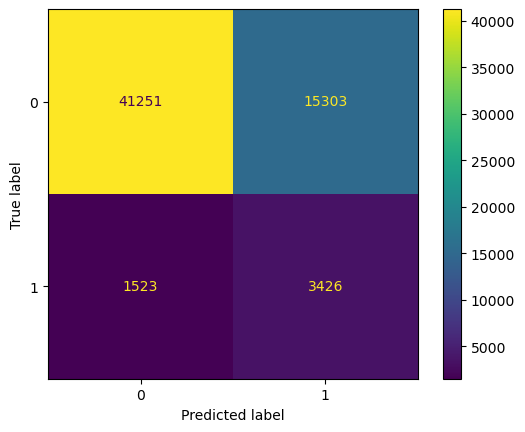

In [121]:
pred_labels = cb.predict(X_test)
cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb.classes_)
disp.plot()
plt.show()

In [122]:
recall_score(y_test, pred_labels), precision_score(y_test, pred_labels), f1_score(y_test, pred_labels)

(0.692261062840978, 0.1829248758609643, 0.2893825492017907)

In [212]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.01)
print(y_val.value_counts())

0    2276
1     185
Name: TARGET, dtype: int64


# Tuning

In [199]:
import optuna
from optuna.integration import CatBoostPruningCallback

In [214]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.01, 0.1, log=True
        ),
        "depth": trial.suggest_int("depth", 1, 15),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "MVS"]
        ),
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    # class_weigths = compute_class_weight(
    #     class_weight="balanced", classes=np.unique(target), y=target
    # )
    gbm = CatBoostClassifier(**param, auto_class_weights="Balanced")

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)

    return auc


study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

with open("best_trial.pkl", "wb") as f:
    pickle.dump(trial, f)

[I 2022-12-13 15:15:22,657] A new study created in memory with name: no-name-fb8723f2-5068-45ed-9116-efd94057f68c
/home/user/miniconda3/envs/torchik/lib/python3.7/site-packages/ipykernel_launcher.py:20: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2022-12-13 15:17:28,342] Trial 0 finished with value: 0.748453570765265 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.018945732422979915, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.748453570765265.
/home/user/miniconda3/envs/torchik/lib/python3.7/site-packages/ipykernel_launcher.py:20: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2022-12-13 15:18:21,317] Trial 1 finished with value: 0.7492439968700657 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.018943714399974748, 'depth': 3, 'boosting_t

Number of finished trials: 51
Best trial:
  Value: 0.764746458363764
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09035054577108488
    depth: 6
    boosting_type: Plain
    bootstrap_type: MVS


In [228]:
best_cb = CatBoostClassifier(
    depth=6,
    task_type="CPU",
    devices="0",
    objective="Logloss",
    colsample_bylevel=0.09,
    boosting_type="Plain",
    bootstrap_type="MVS",
    n_estimators=1000,
)
best_cb.fit(X, y)
best_pred = best_cb.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, best_pred)

Learning rate set to 0.118919
0:	learn: 0.5807899	total: 21.1ms	remaining: 21.1s
1:	learn: 0.4992031	total: 42.7ms	remaining: 21.3s
2:	learn: 0.4394848	total: 63.3ms	remaining: 21s
3:	learn: 0.3911335	total: 86ms	remaining: 21.4s
4:	learn: 0.3592957	total: 106ms	remaining: 21.1s
5:	learn: 0.3347267	total: 126ms	remaining: 20.9s
6:	learn: 0.3178803	total: 147ms	remaining: 20.9s
7:	learn: 0.3039399	total: 170ms	remaining: 21s
8:	learn: 0.2937447	total: 192ms	remaining: 21.1s
9:	learn: 0.2870002	total: 214ms	remaining: 21.2s
10:	learn: 0.2794408	total: 237ms	remaining: 21.3s
11:	learn: 0.2754476	total: 258ms	remaining: 21.3s
12:	learn: 0.2728077	total: 278ms	remaining: 21.1s
13:	learn: 0.2697080	total: 299ms	remaining: 21.1s
14:	learn: 0.2674236	total: 321ms	remaining: 21.1s
15:	learn: 0.2657227	total: 343ms	remaining: 21.1s
16:	learn: 0.2636464	total: 365ms	remaining: 21.1s
17:	learn: 0.2623061	total: 388ms	remaining: 21.2s
18:	learn: 0.2608850	total: 411ms	remaining: 21.2s
19:	learn: 0.

0.8337112887485167

In [26]:
credit_model = CatBoostClassifier(task_type="GPU", devices="0", iterations=1000)
train_pool = Pool(X_train, y_train)
grid = {
    'learning_rate': [0.03, 0.1, 0.5, 0.9],
    'depth':[4, 6, 8]
}
grid_search_results = credit_model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6615192	test: 0.6615566	best: 0.6615566 (0)	total: 21.1ms	remaining: 21s
1:	learn: 0.6333650	test: 0.6334528	best: 0.6334528 (1)	total: 40.8ms	remaining: 20.4s
2:	learn: 0.6064000	test: 0.6064746	best: 0.6064746 (2)	total: 60.9ms	remaining: 20.2s
3:	learn: 0.5803175	test: 0.5804088	best: 0.5804088 (3)	total: 81ms	remaining: 20.2s
4:	learn: 0.5559140	test: 0.5560032	best: 0.5560032 (4)	total: 101ms	remaining: 20.1s
5:	learn: 0.5339984	test: 0.5341202	best: 0.5341202 (5)	total: 120ms	remaining: 19.9s
6:	learn: 0.5145682	test: 0.5147027	best: 0.5147027 (6)	total: 138ms	remaining: 19.5s
7:	learn: 0.4963139	test: 0.4964805	best: 0.4964805 (7)	total: 157ms	remaining: 19.4s
8:	learn: 0.4797282	test: 0.4798853	best: 0.4798853 (8)	total: 175ms	remaining: 19.3s
9:	learn: 0.4639768	test: 0.4641229	best: 0.4641229 (9)	total: 194ms	remaining: 19.2s
10:	learn: 0.4495482	test: 0.4497216	best: 0.4497216 (10)	total: 213ms	remaining: 19.2s
11:	learn: 0.4355031	test: 0.4356872	best: 0.4356872

In [29]:
grid_search_results["params"]

{'depth': 4, 'learning_rate': 0.1}

In [28]:
roc_auc_score(y_test, credit_model.predict_proba(X_test)[:, 1])

0.766692874027247

# Submission

In [47]:
submission = cb.predict_proba(test.set_index("SK_ID_CURR"))[:, 1]
submission = pd.DataFrame(
    submission, index=test["SK_ID_CURR"].astype(np.int64), columns=["TARGET"]
)
submission.to_csv(f"{DATA_PATH}/submission.csv")